In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding

In [35]:
df = pd.read_csv(r"C:\python\research\experiments\datasets\TimeBasedFeatures-Dataset-15s-VPN.csv")
df = df.drop(columns=['Unnamed: 0'])
df.head()

In [4]:
class vpnDataset(Dataset):
    def __init__(self, df, target = 'class1'):
        self.n = df.shape[0]
        
        self.y = df[target].astype(np.float32).values

        self.x = df.drop(columns=[target]).astype(np.float32).values

    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [5]:
vpn_dataset = vpnDataset(df)
train_size = int(0.7*len(vpn_dataset))
print(train_size)
test_size = len(vpn_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(vpn_dataset, [train_size, test_size])
print(len(train_dataset), len(test_dataset))

13130
13130 5628


In [23]:
batch_sz = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_sz, shuffle=True)

### This version only does RFF encoding and then passes the embeddings directly to transformer.

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, key_len, self.heads, self.head_dim)
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        # if mask is not None:
        #     energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim)
        out = self.fc_out(out)
        return out
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()

        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Encoder(nn.Module):
    def __init__(self,
                 sigma,
                 embed_size,
                 input_size,
                 n_features,
                 num_layers,
                 heads,
                 forward_expansion,
                 dropout
    ):
        super(Encoder, self).__init__()

        self.embed_size = embed_size
        self.embeddings = GaussianEncoding(sigma = sigma, input_size=input_size, encoded_size=embed_size//2) 
        
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion
                )
                for _ in range(num_layers)
            ]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #(batch_size, n_features) -> (batch_size, n_features, 1)
        x = x.unsqueeze(2)
    
        x = self.embeddings(x) #(batch_size, n_features, emb_size)

        x = self.dropout(x)

        for layer in self.layers:
            #running embeddings through transformer block
            #keys, values, and query are all the same initially (x)
            x = layer(x, x, x)
     
        return x #same dimensions as going in 


In [8]:
class classificationHead(nn.Module):
    def __init__(self, n_features, embed_size, dropout):
        super(classificationHead, self).__init__()

        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.n_features = n_features*embed_size
        self.lin1 = nn.Linear(self.n_features, self.n_features//2)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(self.n_features//2, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin2.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin2.bias)

    def forward(self, x):
        x= torch.reshape(x, (-1, self.n_features))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.sigmoid(x)
  
        return x.squeeze(1)

In [9]:
class vpnClassifier(nn.Module):
    def __init__(self, 
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 n_features=23,
                 num_layers=2,
                 heads=4,
                 forward_expansion=4,
                 dropout=.5,
                 ):
        super(vpnClassifier, self).__init__()
        self.encoder = Encoder(sigma=sigma, embed_size=embed_size, input_size=input_size, n_features=n_features, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, dropout=dropout)
        self.classifying_head = classificationHead(n_features=n_features, embed_size=embed_size, dropout=dropout)
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifying_head(x)
        return x


In [10]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        # print(batch_idx, inputs, targets)
        pred = model(inputs)
        # print(pred)
        # print(pred.squeeze(0))
        loss = loss_fn(pred, targets)
        total_loss+= loss.item()

        # Calculate accuracy
        predicted_labels = (pred>0.5).float()
        # print(predicted_labels)
        total_correct += (predicted_labels == targets).sum().item()
        # print(total_correct)
        total_samples += targets.size(0)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy
    

def test(dataloader, model, loss_fn):
  model.eval()
  tot = 0
  total_correct = 0
  total_samples = 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(dataloader):
      #compute prediction error
      pred = model(inputs)
      test_loss = loss_fn(pred, targets)
      tot += test_loss

      # Calculate accuracy
      predicted_labels = (pred>0.5).float()
      # print(predicted_labels)
      total_correct += (predicted_labels == targets).sum().item()
      # print(total_correct)
      total_samples += targets.size(0)

  avg = tot/len(dataloader)
  accuracy = total_correct / total_samples

  return avg, accuracy

Epoch 1/15, Train Loss: 1.1780, Test Loss: 0.7473, Train Accuracy: 0.5073, Test Accuracy: 0.5464
Epoch 2/15, Train Loss: 1.1005, Test Loss: 0.7181, Train Accuracy: 0.5161, Test Accuracy: 0.5606
Epoch 3/15, Train Loss: 1.0319, Test Loss: 0.6970, Train Accuracy: 0.5196, Test Accuracy: 0.5698
Epoch 4/15, Train Loss: 0.9748, Test Loss: 0.6859, Train Accuracy: 0.5236, Test Accuracy: 0.5734
Epoch 5/15, Train Loss: 0.9380, Test Loss: 0.6727, Train Accuracy: 0.5174, Test Accuracy: 0.5743
Epoch 6/15, Train Loss: 0.8782, Test Loss: 0.6741, Train Accuracy: 0.5311, Test Accuracy: 0.5622
Epoch 7/15, Train Loss: 0.8417, Test Loss: 0.6694, Train Accuracy: 0.5322, Test Accuracy: 0.5640
Epoch 8/15, Train Loss: 0.8138, Test Loss: 0.6685, Train Accuracy: 0.5334, Test Accuracy: 0.5599
Epoch 9/15, Train Loss: 0.7864, Test Loss: 0.6658, Train Accuracy: 0.5379, Test Accuracy: 0.5625
Epoch 10/15, Train Loss: 0.7686, Test Loss: 0.6658, Train Accuracy: 0.5343, Test Accuracy: 0.5601
Epoch 11/15, Train Loss: 0.75

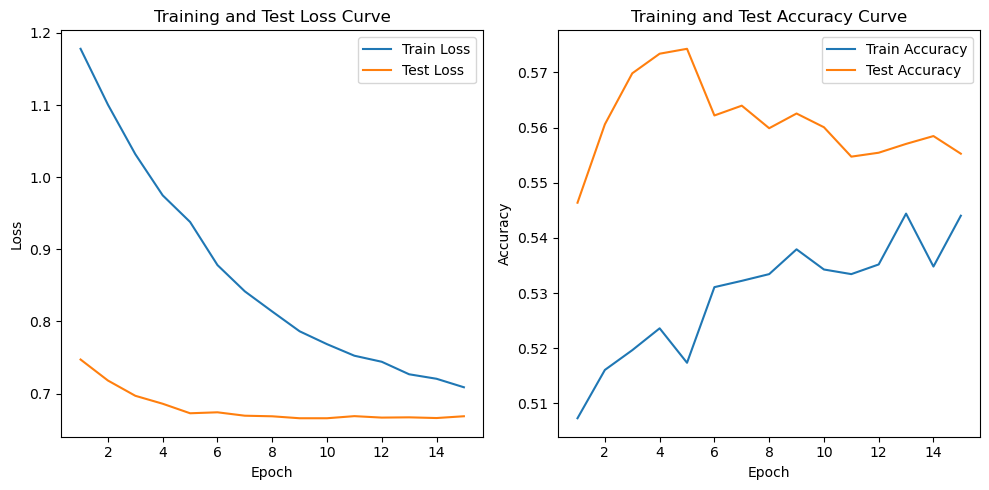

Best accuracy: 0.574271499644634


In [18]:
model = vpnClassifier(embed_size=30, num_layers=1, heads=10, dropout=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 15
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/50, Train Loss: 1.2493, Test Loss: 0.8987, Train Accuracy: 0.4903, Test Accuracy: 0.5146
Epoch 2/50, Train Loss: 1.1342, Test Loss: 0.7734, Train Accuracy: 0.5027, Test Accuracy: 0.5243
Epoch 3/50, Train Loss: 1.0635, Test Loss: 0.7391, Train Accuracy: 0.5072, Test Accuracy: 0.5377
Epoch 4/50, Train Loss: 1.0188, Test Loss: 0.7029, Train Accuracy: 0.5041, Test Accuracy: 0.5494
Epoch 5/50, Train Loss: 0.9727, Test Loss: 0.6857, Train Accuracy: 0.5027, Test Accuracy: 0.5608
Epoch 6/50, Train Loss: 0.9147, Test Loss: 0.6788, Train Accuracy: 0.5142, Test Accuracy: 0.5670
Epoch 7/50, Train Loss: 0.8909, Test Loss: 0.6745, Train Accuracy: 0.5023, Test Accuracy: 0.5684
Epoch 8/50, Train Loss: 0.8448, Test Loss: 0.6720, Train Accuracy: 0.5101, Test Accuracy: 0.5688
Epoch 9/50, Train Loss: 0.8056, Test Loss: 0.6719, Train Accuracy: 0.5250, Test Accuracy: 0.5682
Epoch 10/50, Train Loss: 0.7931, Test Loss: 0.6725, Train Accuracy: 0.5041, Test Accuracy: 0.5709
Epoch 11/50, Train Loss: 0.76

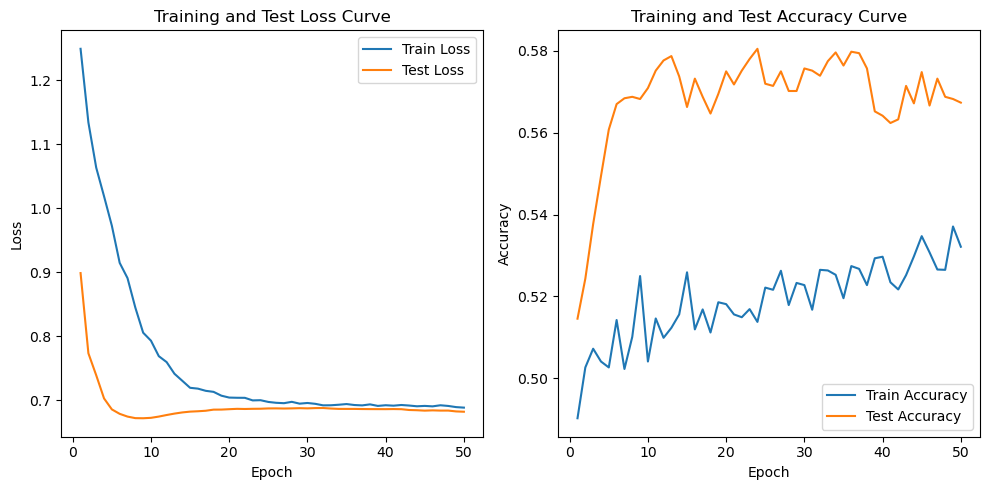

Best accuracy: 0.5804904051172708


In [11]:
model = vpnClassifier(embed_size=30, num_layers=2, heads=15, dropout=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 50
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/50, Train Loss: 1.7934, Test Loss: 0.9402, Train Accuracy: 0.5148, Test Accuracy: 0.5199
Epoch 2/50, Train Loss: 1.7245, Test Loss: 0.8833, Train Accuracy: 0.5075, Test Accuracy: 0.5185
Epoch 3/50, Train Loss: 1.6593, Test Loss: 0.8574, Train Accuracy: 0.5158, Test Accuracy: 0.5030
Epoch 4/50, Train Loss: 1.6226, Test Loss: 0.8546, Train Accuracy: 0.5084, Test Accuracy: 0.4966
Epoch 5/50, Train Loss: 1.5870, Test Loss: 0.8651, Train Accuracy: 0.5107, Test Accuracy: 0.4941
Epoch 6/50, Train Loss: 1.5544, Test Loss: 0.8849, Train Accuracy: 0.5124, Test Accuracy: 0.4941
Epoch 7/50, Train Loss: 1.5573, Test Loss: 0.9079, Train Accuracy: 0.5021, Test Accuracy: 0.4879
Epoch 8/50, Train Loss: 1.4954, Test Loss: 0.9291, Train Accuracy: 0.5087, Test Accuracy: 0.4888
Epoch 9/50, Train Loss: 1.5430, Test Loss: 0.9452, Train Accuracy: 0.4992, Test Accuracy: 0.4865
Epoch 10/50, Train Loss: 1.5229, Test Loss: 0.9594, Train Accuracy: 0.5018, Test Accuracy: 0.4885
Epoch 11/50, Train Loss: 1.51

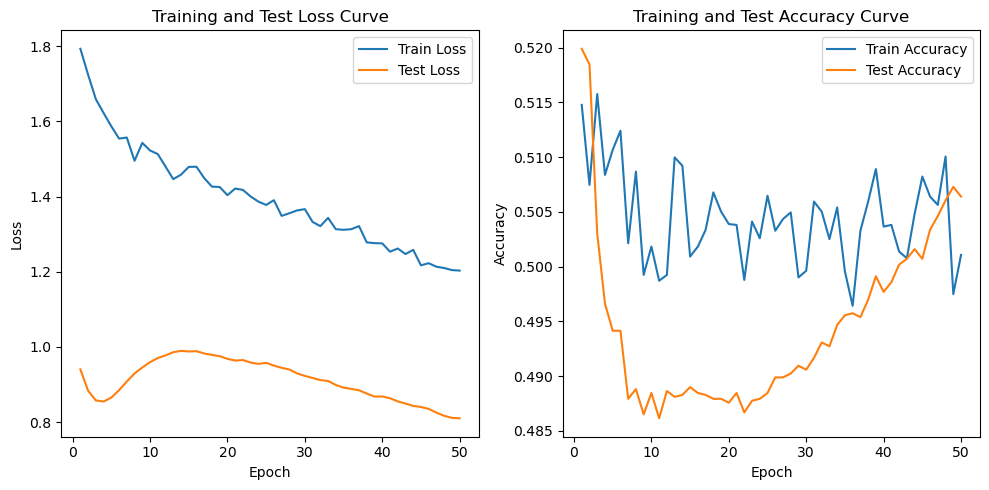

Best accuracy: 0.5199004975124378


In [12]:
model = vpnClassifier(sigma=5, embed_size=30, num_layers=2, heads=5, dropout=0.6)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

epochs = 50
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/50, Train Loss: 1.4457, Test Loss: 0.7859, Train Accuracy: 0.4906, Test Accuracy: 0.4980
Epoch 2/50, Train Loss: 1.3250, Test Loss: 0.7540, Train Accuracy: 0.5026, Test Accuracy: 0.5025
Epoch 3/50, Train Loss: 1.2725, Test Loss: 0.7307, Train Accuracy: 0.4931, Test Accuracy: 0.5155
Epoch 4/50, Train Loss: 1.1858, Test Loss: 0.7144, Train Accuracy: 0.4987, Test Accuracy: 0.5220
Epoch 5/50, Train Loss: 1.1265, Test Loss: 0.7003, Train Accuracy: 0.4982, Test Accuracy: 0.5325
Epoch 6/50, Train Loss: 1.0283, Test Loss: 0.6923, Train Accuracy: 0.5039, Test Accuracy: 0.5302
Epoch 7/50, Train Loss: 0.9698, Test Loss: 0.6889, Train Accuracy: 0.5017, Test Accuracy: 0.5386
Epoch 8/50, Train Loss: 0.9105, Test Loss: 0.6908, Train Accuracy: 0.5018, Test Accuracy: 0.5313
Epoch 9/50, Train Loss: 0.8620, Test Loss: 0.6895, Train Accuracy: 0.5038, Test Accuracy: 0.5306
Epoch 10/50, Train Loss: 0.8265, Test Loss: 0.6901, Train Accuracy: 0.5094, Test Accuracy: 0.5288
Epoch 11/50, Train Loss: 0.79

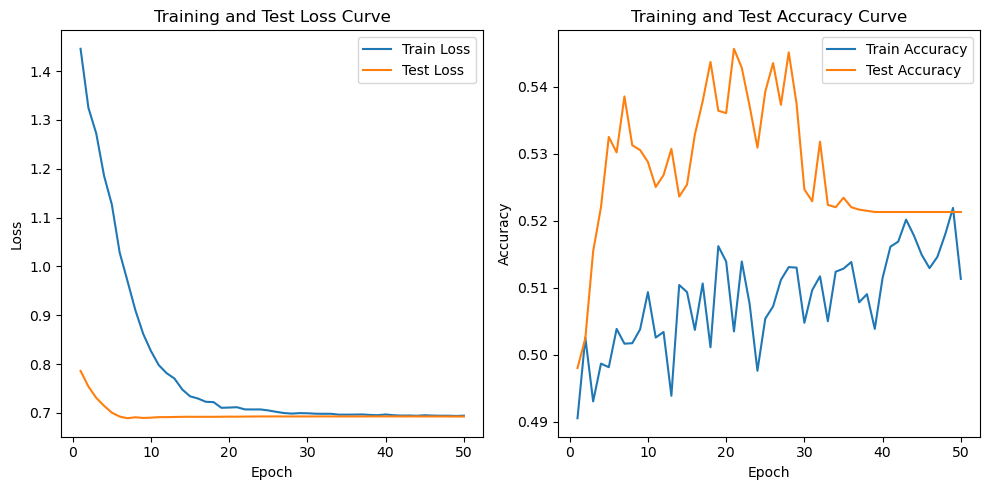

Best accuracy: 0.5456645344705047


In [13]:
model = vpnClassifier(sigma=5, embed_size=30, num_layers=2, heads=5, dropout=0.6)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 50
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/50, Train Loss: 1.4780, Test Loss: 0.7916, Train Accuracy: 0.5032, Test Accuracy: 0.5213
Epoch 2/50, Train Loss: 1.4274, Test Loss: 0.7769, Train Accuracy: 0.4972, Test Accuracy: 0.5243
Epoch 3/50, Train Loss: 1.3194, Test Loss: 0.7491, Train Accuracy: 0.5059, Test Accuracy: 0.5306
Epoch 4/50, Train Loss: 1.2415, Test Loss: 0.7409, Train Accuracy: 0.5025, Test Accuracy: 0.5297
Epoch 5/50, Train Loss: 1.1637, Test Loss: 0.7342, Train Accuracy: 0.5072, Test Accuracy: 0.5206
Epoch 6/50, Train Loss: 1.0951, Test Loss: 0.7143, Train Accuracy: 0.5039, Test Accuracy: 0.5261
Epoch 7/50, Train Loss: 1.0371, Test Loss: 0.7126, Train Accuracy: 0.4998, Test Accuracy: 0.5163
Epoch 8/50, Train Loss: 0.9707, Test Loss: 0.6975, Train Accuracy: 0.4934, Test Accuracy: 0.5213
Epoch 9/50, Train Loss: 0.9048, Test Loss: 0.6974, Train Accuracy: 0.5092, Test Accuracy: 0.5171
Epoch 10/50, Train Loss: 0.8580, Test Loss: 0.6917, Train Accuracy: 0.5025, Test Accuracy: 0.5277
Epoch 11/50, Train Loss: 0.82

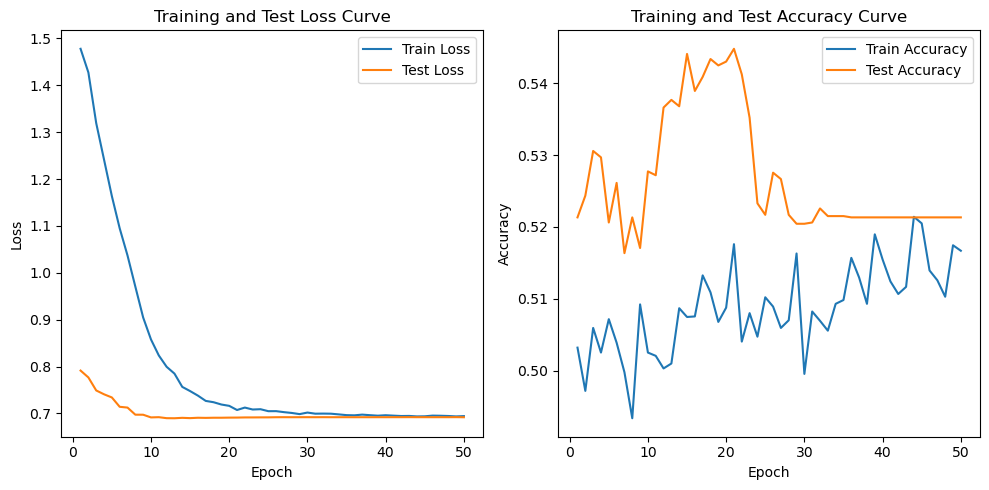

Best accuracy: 0.5447761194029851


In [14]:
model = vpnClassifier(sigma=3, embed_size=30, num_layers=2, heads=5, dropout=0.6)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 50
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/50, Train Loss: 1.5134, Test Loss: 0.7730, Train Accuracy: 0.4941, Test Accuracy: 0.5199
Epoch 2/50, Train Loss: 1.3768, Test Loss: 0.7334, Train Accuracy: 0.5055, Test Accuracy: 0.5220
Epoch 3/50, Train Loss: 1.3142, Test Loss: 0.7182, Train Accuracy: 0.4989, Test Accuracy: 0.5288
Epoch 4/50, Train Loss: 1.2584, Test Loss: 0.7104, Train Accuracy: 0.4953, Test Accuracy: 0.5373
Epoch 5/50, Train Loss: 1.1986, Test Loss: 0.7050, Train Accuracy: 0.4976, Test Accuracy: 0.5380
Epoch 6/50, Train Loss: 1.1205, Test Loss: 0.7002, Train Accuracy: 0.4982, Test Accuracy: 0.5348
Epoch 7/50, Train Loss: 1.0581, Test Loss: 0.6965, Train Accuracy: 0.4960, Test Accuracy: 0.5339
Epoch 8/50, Train Loss: 0.9893, Test Loss: 0.6911, Train Accuracy: 0.5034, Test Accuracy: 0.5334
Epoch 9/50, Train Loss: 0.9291, Test Loss: 0.6903, Train Accuracy: 0.5055, Test Accuracy: 0.5330
Epoch 10/50, Train Loss: 0.8975, Test Loss: 0.6891, Train Accuracy: 0.5002, Test Accuracy: 0.5304
Epoch 11/50, Train Loss: 0.84

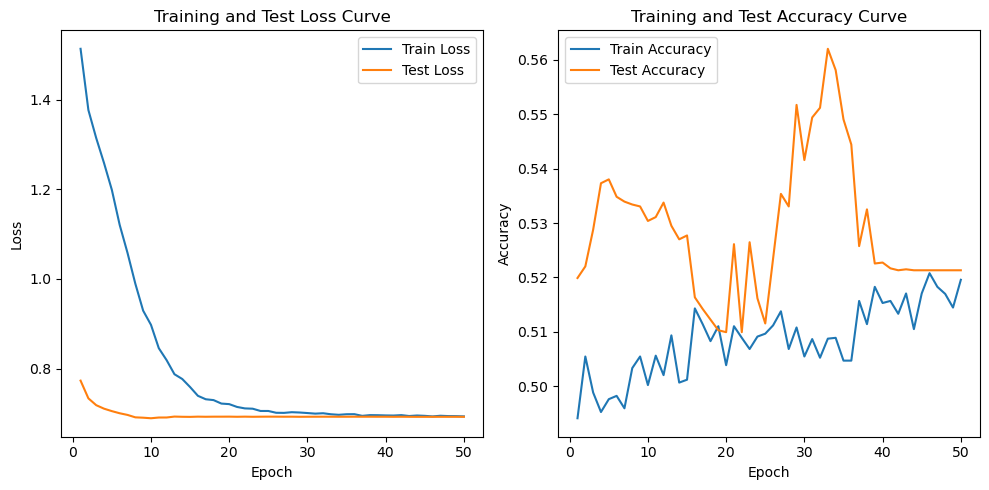

Best accuracy: 0.5620113717128643


In [15]:
model = vpnClassifier(sigma=4, embed_size=30, num_layers=2, heads=5, dropout=0.6)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 50
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/50, Train Loss: 1.2885, Test Loss: 0.7465, Train Accuracy: 0.5002, Test Accuracy: 0.5174
Epoch 2/50, Train Loss: 0.9464, Test Loss: 0.6907, Train Accuracy: 0.5063, Test Accuracy: 0.5402
Epoch 3/50, Train Loss: 0.7791, Test Loss: 0.6908, Train Accuracy: 0.5021, Test Accuracy: 0.5419
Epoch 4/50, Train Loss: 0.7249, Test Loss: 0.6917, Train Accuracy: 0.5065, Test Accuracy: 0.5215
Epoch 5/50, Train Loss: 0.7107, Test Loss: 0.6918, Train Accuracy: 0.5043, Test Accuracy: 0.5423
Epoch 6/50, Train Loss: 0.7025, Test Loss: 0.6923, Train Accuracy: 0.5072, Test Accuracy: 0.5489
Epoch 7/50, Train Loss: 0.6979, Test Loss: 0.6922, Train Accuracy: 0.5111, Test Accuracy: 0.5213
Epoch 8/50, Train Loss: 0.6961, Test Loss: 0.6923, Train Accuracy: 0.5134, Test Accuracy: 0.5213
Epoch 9/50, Train Loss: 0.6946, Test Loss: 0.6920, Train Accuracy: 0.5196, Test Accuracy: 0.5213
Epoch 10/50, Train Loss: 0.6943, Test Loss: 0.6921, Train Accuracy: 0.5178, Test Accuracy: 0.5213
Epoch 11/50, Train Loss: 0.69

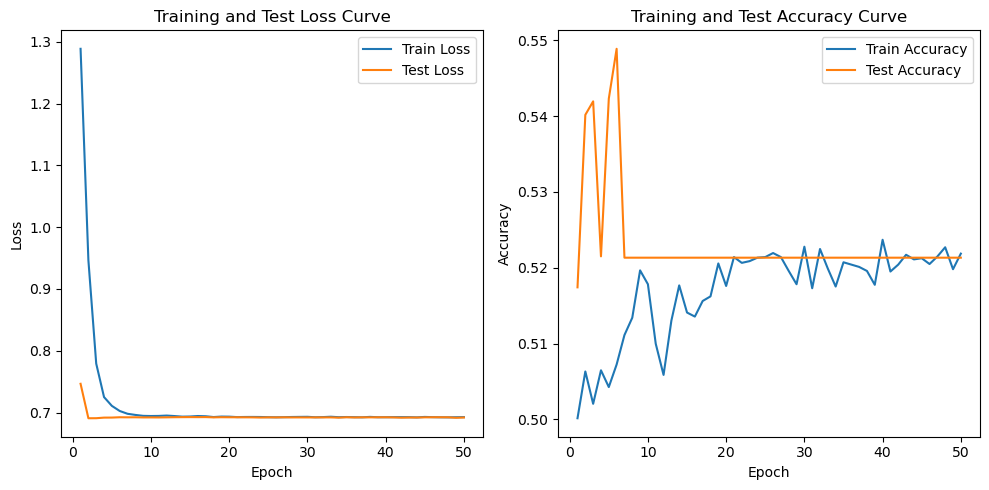

Best accuracy: 0.548862828713575


In [16]:
model = vpnClassifier(sigma=4, embed_size=30, num_layers=2, heads=5, dropout=0.6)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

epochs = 50
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/50, Train Loss: 1.2445, Test Loss: 0.9461, Train Accuracy: 0.5168, Test Accuracy: 0.5277
Epoch 2/50, Train Loss: 1.1414, Test Loss: 0.8057, Train Accuracy: 0.5222, Test Accuracy: 0.5407
Epoch 3/50, Train Loss: 1.0840, Test Loss: 0.7588, Train Accuracy: 0.5182, Test Accuracy: 0.5471
Epoch 4/50, Train Loss: 1.0335, Test Loss: 0.7213, Train Accuracy: 0.5226, Test Accuracy: 0.5526
Epoch 5/50, Train Loss: 0.9928, Test Loss: 0.7036, Train Accuracy: 0.5233, Test Accuracy: 0.5561
Epoch 6/50, Train Loss: 0.9503, Test Loss: 0.6858, Train Accuracy: 0.5212, Test Accuracy: 0.5618
Epoch 7/50, Train Loss: 0.9081, Test Loss: 0.6770, Train Accuracy: 0.5284, Test Accuracy: 0.5677
Epoch 8/50, Train Loss: 0.8690, Test Loss: 0.6688, Train Accuracy: 0.5304, Test Accuracy: 0.5769
Epoch 9/50, Train Loss: 0.8416, Test Loss: 0.6637, Train Accuracy: 0.5364, Test Accuracy: 0.5807
Epoch 10/50, Train Loss: 0.8152, Test Loss: 0.6612, Train Accuracy: 0.5295, Test Accuracy: 0.5826
Epoch 11/50, Train Loss: 0.79

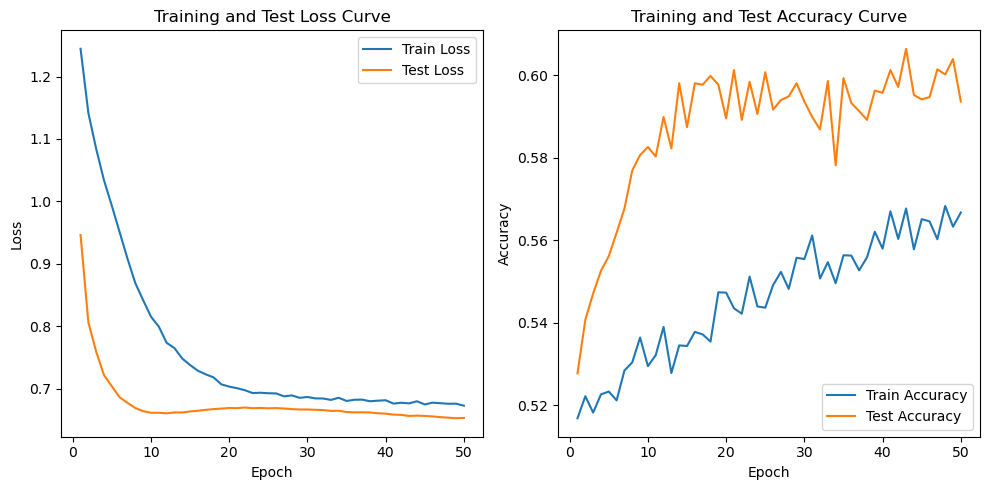

Best accuracy: 0.6064321250888415


In [20]:
model = vpnClassifier(sigma=4, embed_size=30, num_layers=1, heads=5, dropout=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 50
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/50, Train Loss: 1.1913, Test Loss: 0.7587, Train Accuracy: 0.5113, Test Accuracy: 0.5346
Epoch 2/50, Train Loss: 1.1092, Test Loss: 0.7166, Train Accuracy: 0.5059, Test Accuracy: 0.5432
Epoch 3/50, Train Loss: 1.0707, Test Loss: 0.7040, Train Accuracy: 0.5051, Test Accuracy: 0.5426
Epoch 4/50, Train Loss: 1.0192, Test Loss: 0.6984, Train Accuracy: 0.5079, Test Accuracy: 0.5418
Epoch 5/50, Train Loss: 0.9701, Test Loss: 0.7014, Train Accuracy: 0.5065, Test Accuracy: 0.5425
Epoch 6/50, Train Loss: 0.9286, Test Loss: 0.6999, Train Accuracy: 0.5016, Test Accuracy: 0.5428
Epoch 7/50, Train Loss: 0.8917, Test Loss: 0.6971, Train Accuracy: 0.5014, Test Accuracy: 0.5464
Epoch 8/50, Train Loss: 0.8536, Test Loss: 0.6979, Train Accuracy: 0.5046, Test Accuracy: 0.5371
Epoch 9/50, Train Loss: 0.8159, Test Loss: 0.6958, Train Accuracy: 0.5075, Test Accuracy: 0.5339
Epoch 10/50, Train Loss: 0.7876, Test Loss: 0.6934, Train Accuracy: 0.5101, Test Accuracy: 0.5302
Epoch 11/50, Train Loss: 0.77

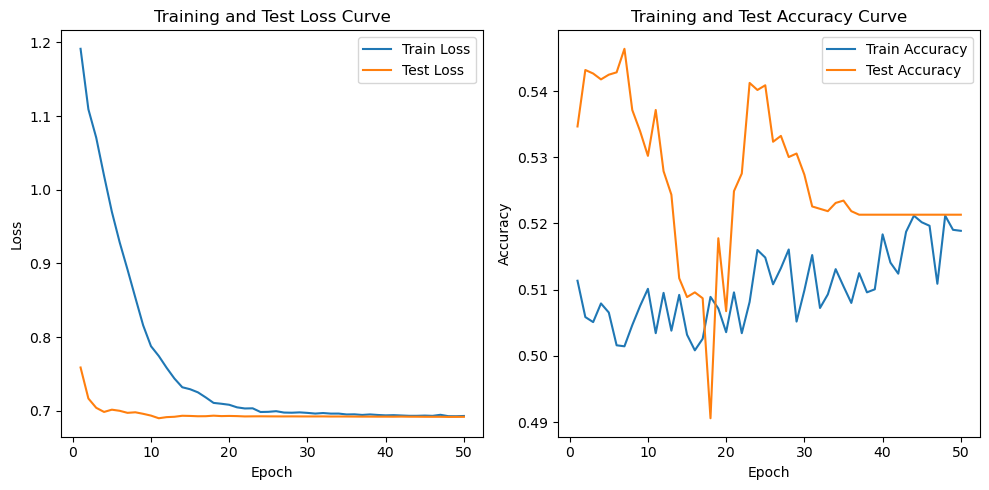

Best accuracy: 0.5463752665245203


In [19]:
model = vpnClassifier(sigma=4, embed_size=30, num_layers=3, heads=5, dropout=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 50
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/50, Train Loss: 1.2414, Test Loss: 0.7763, Train Accuracy: 0.4971, Test Accuracy: 0.5211
Epoch 2/50, Train Loss: 1.1325, Test Loss: 0.7214, Train Accuracy: 0.5114, Test Accuracy: 0.5524
Epoch 3/50, Train Loss: 1.0525, Test Loss: 0.7005, Train Accuracy: 0.5187, Test Accuracy: 0.5656
Epoch 4/50, Train Loss: 1.0081, Test Loss: 0.6910, Train Accuracy: 0.5181, Test Accuracy: 0.5675
Epoch 5/50, Train Loss: 0.9623, Test Loss: 0.6827, Train Accuracy: 0.5221, Test Accuracy: 0.5663
Epoch 6/50, Train Loss: 0.9331, Test Loss: 0.6733, Train Accuracy: 0.5186, Test Accuracy: 0.5684
Epoch 7/50, Train Loss: 0.8921, Test Loss: 0.6669, Train Accuracy: 0.5256, Test Accuracy: 0.5748
Epoch 8/50, Train Loss: 0.8550, Test Loss: 0.6675, Train Accuracy: 0.5299, Test Accuracy: 0.5634
Epoch 9/50, Train Loss: 0.8199, Test Loss: 0.6638, Train Accuracy: 0.5366, Test Accuracy: 0.5649
Epoch 10/50, Train Loss: 0.8036, Test Loss: 0.6598, Train Accuracy: 0.5275, Test Accuracy: 0.5824
Epoch 11/50, Train Loss: 0.77

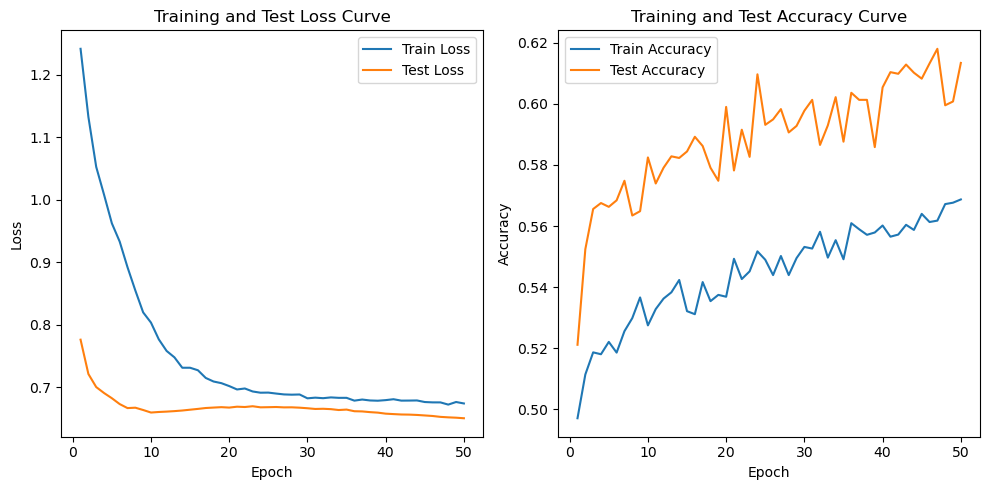

Best accuracy: 0.6179815209665956


In [21]:
model = vpnClassifier(sigma=4, embed_size=30, num_layers=1, heads=15, dropout=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 50
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/75, Train Loss: 1.2157, Test Loss: 0.7329, Train Accuracy: 0.5073, Test Accuracy: 0.5482
Epoch 2/75, Train Loss: 1.1424, Test Loss: 0.7010, Train Accuracy: 0.5205, Test Accuracy: 0.5697
Epoch 3/75, Train Loss: 1.0762, Test Loss: 0.6769, Train Accuracy: 0.5200, Test Accuracy: 0.5871
Epoch 4/75, Train Loss: 1.0132, Test Loss: 0.6738, Train Accuracy: 0.5272, Test Accuracy: 0.5828
Epoch 5/75, Train Loss: 0.9621, Test Loss: 0.6642, Train Accuracy: 0.5264, Test Accuracy: 0.5871
Epoch 6/75, Train Loss: 0.9281, Test Loss: 0.6590, Train Accuracy: 0.5353, Test Accuracy: 0.5869
Epoch 7/75, Train Loss: 0.9080, Test Loss: 0.6507, Train Accuracy: 0.5307, Test Accuracy: 0.5952
Epoch 8/75, Train Loss: 0.8684, Test Loss: 0.6473, Train Accuracy: 0.5324, Test Accuracy: 0.5983
Epoch 9/75, Train Loss: 0.8352, Test Loss: 0.6458, Train Accuracy: 0.5406, Test Accuracy: 0.6002
Epoch 10/75, Train Loss: 0.8079, Test Loss: 0.6464, Train Accuracy: 0.5379, Test Accuracy: 0.5981
Epoch 11/75, Train Loss: 0.79

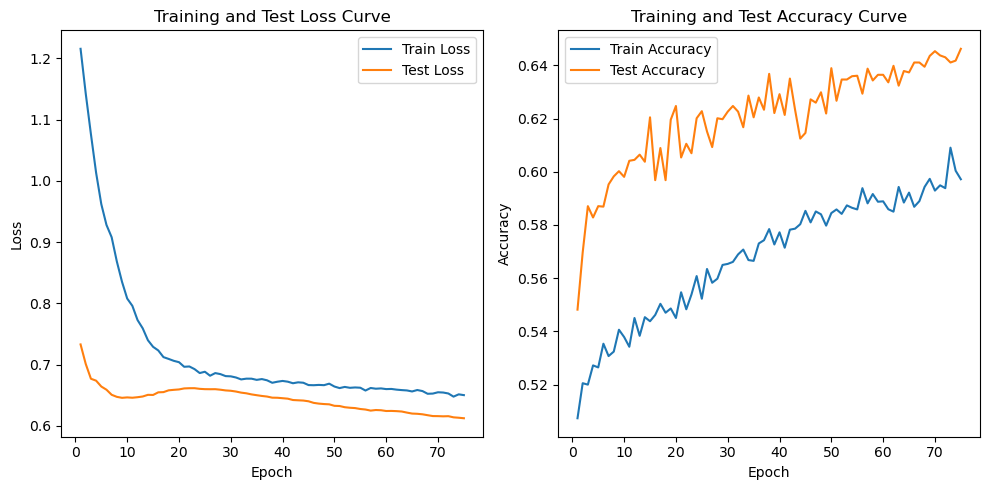

Best accuracy: 0.6462331201137171


In [22]:
model = vpnClassifier(sigma=4, embed_size=30, num_layers=1, heads=15, dropout=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 75
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/90, Train Loss: 1.2061, Test Loss: 0.7814, Train Accuracy: 0.5002, Test Accuracy: 0.5254
Epoch 2/90, Train Loss: 1.1051, Test Loss: 0.7186, Train Accuracy: 0.5036, Test Accuracy: 0.5506
Epoch 3/90, Train Loss: 1.0392, Test Loss: 0.6955, Train Accuracy: 0.5117, Test Accuracy: 0.5633
Epoch 4/90, Train Loss: 0.9653, Test Loss: 0.6845, Train Accuracy: 0.5188, Test Accuracy: 0.5729
Epoch 5/90, Train Loss: 0.9262, Test Loss: 0.6764, Train Accuracy: 0.5244, Test Accuracy: 0.5791
Epoch 6/90, Train Loss: 0.8813, Test Loss: 0.6720, Train Accuracy: 0.5255, Test Accuracy: 0.5821
Epoch 7/90, Train Loss: 0.8551, Test Loss: 0.6700, Train Accuracy: 0.5307, Test Accuracy: 0.5718
Epoch 8/90, Train Loss: 0.8216, Test Loss: 0.6687, Train Accuracy: 0.5290, Test Accuracy: 0.5720
Epoch 9/90, Train Loss: 0.7971, Test Loss: 0.6693, Train Accuracy: 0.5338, Test Accuracy: 0.5675
Epoch 10/90, Train Loss: 0.7765, Test Loss: 0.6675, Train Accuracy: 0.5333, Test Accuracy: 0.5791
Epoch 11/90, Train Loss: 0.75

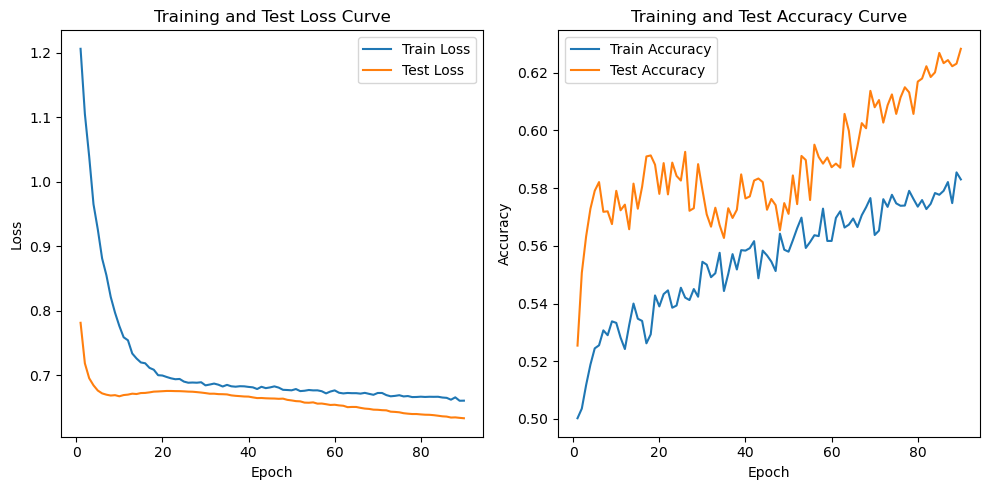

Best accuracy: 0.6282871357498223


In [24]:
model = vpnClassifier(sigma=4, embed_size=30, num_layers=1, heads=15, dropout=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 90
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/150, Train Loss: 1.2104, Test Loss: 0.7392, Train Accuracy: 0.5109, Test Accuracy: 0.5483
Epoch 2/150, Train Loss: 1.1264, Test Loss: 0.7133, Train Accuracy: 0.5166, Test Accuracy: 0.5725
Epoch 3/150, Train Loss: 1.0732, Test Loss: 0.6840, Train Accuracy: 0.5188, Test Accuracy: 0.5878
Epoch 4/150, Train Loss: 0.9970, Test Loss: 0.6667, Train Accuracy: 0.5258, Test Accuracy: 0.5981
Epoch 5/150, Train Loss: 0.9604, Test Loss: 0.6600, Train Accuracy: 0.5274, Test Accuracy: 0.5959
Epoch 6/150, Train Loss: 0.9044, Test Loss: 0.6594, Train Accuracy: 0.5347, Test Accuracy: 0.5856
Epoch 7/150, Train Loss: 0.8855, Test Loss: 0.6523, Train Accuracy: 0.5298, Test Accuracy: 0.5952
Epoch 8/150, Train Loss: 0.8442, Test Loss: 0.6526, Train Accuracy: 0.5368, Test Accuracy: 0.5940
Epoch 9/150, Train Loss: 0.8216, Test Loss: 0.6535, Train Accuracy: 0.5333, Test Accuracy: 0.5936
Epoch 10/150, Train Loss: 0.7864, Test Loss: 0.6519, Train Accuracy: 0.5320, Test Accuracy: 0.6125
Epoch 11/150, Train

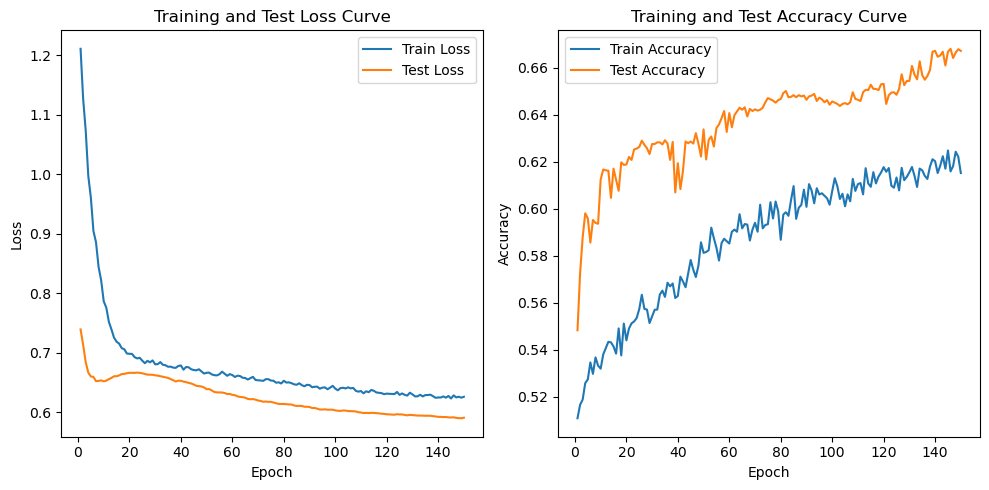

Best accuracy: 0.668088130774698


In [25]:
model = vpnClassifier(sigma=4, embed_size=30, num_layers=1, heads=15, dropout=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 150
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/150, Train Loss: 1.0931, Test Loss: 0.6924, Train Accuracy: 0.5127, Test Accuracy: 0.5844
Epoch 2/150, Train Loss: 0.9821, Test Loss: 0.6727, Train Accuracy: 0.5250, Test Accuracy: 0.5910
Epoch 3/150, Train Loss: 0.9254, Test Loss: 0.6608, Train Accuracy: 0.5290, Test Accuracy: 0.6011
Epoch 4/150, Train Loss: 0.8759, Test Loss: 0.6558, Train Accuracy: 0.5353, Test Accuracy: 0.5974
Epoch 5/150, Train Loss: 0.8335, Test Loss: 0.6536, Train Accuracy: 0.5337, Test Accuracy: 0.5997
Epoch 6/150, Train Loss: 0.8029, Test Loss: 0.6545, Train Accuracy: 0.5327, Test Accuracy: 0.6020
Epoch 7/150, Train Loss: 0.7894, Test Loss: 0.6577, Train Accuracy: 0.5308, Test Accuracy: 0.6031
Epoch 8/150, Train Loss: 0.7510, Test Loss: 0.6590, Train Accuracy: 0.5417, Test Accuracy: 0.6089
Epoch 9/150, Train Loss: 0.7306, Test Loss: 0.6605, Train Accuracy: 0.5440, Test Accuracy: 0.6009
Epoch 10/150, Train Loss: 0.7232, Test Loss: 0.6625, Train Accuracy: 0.5432, Test Accuracy: 0.5951
Epoch 11/150, Train

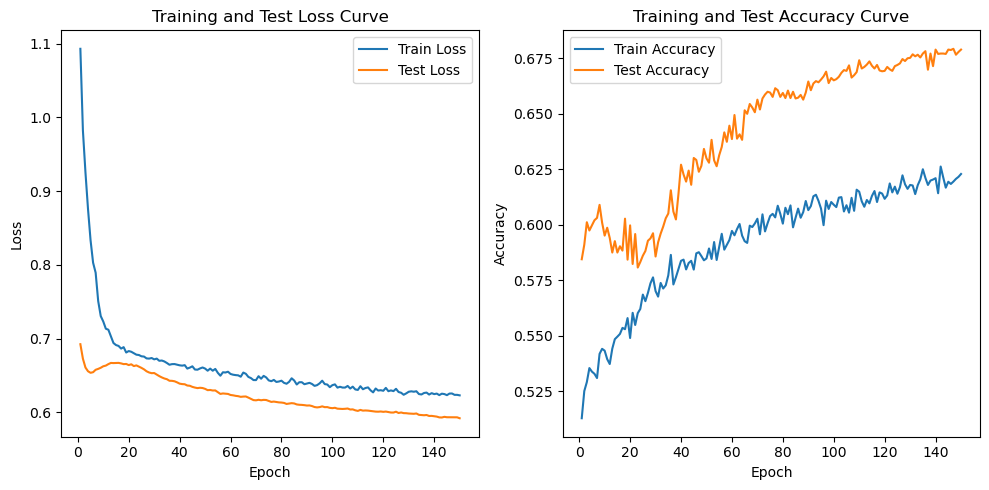

Best accuracy: 0.6792821606254442


In [26]:
model = vpnClassifier(sigma=4, embed_size=30, num_layers=1, heads=15, dropout=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.0001)

epochs = 150
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/150, Train Loss: 0.8542, Test Loss: 0.6794, Train Accuracy: 0.5421, Test Accuracy: 0.5446
Epoch 2/150, Train Loss: 0.6887, Test Loss: 0.6730, Train Accuracy: 0.5471, Test Accuracy: 0.5725
Epoch 3/150, Train Loss: 0.6813, Test Loss: 0.6514, Train Accuracy: 0.5570, Test Accuracy: 0.5999
Epoch 4/150, Train Loss: 0.6734, Test Loss: 0.6396, Train Accuracy: 0.5720, Test Accuracy: 0.6246
Epoch 5/150, Train Loss: 0.6659, Test Loss: 0.6288, Train Accuracy: 0.5800, Test Accuracy: 0.6196
Epoch 6/150, Train Loss: 0.6592, Test Loss: 0.6186, Train Accuracy: 0.5900, Test Accuracy: 0.6441
Epoch 7/150, Train Loss: 0.6537, Test Loss: 0.6060, Train Accuracy: 0.5989, Test Accuracy: 0.6658
Epoch 8/150, Train Loss: 0.6499, Test Loss: 0.6053, Train Accuracy: 0.6018, Test Accuracy: 0.6629
Epoch 9/150, Train Loss: 0.6412, Test Loss: 0.5979, Train Accuracy: 0.6103, Test Accuracy: 0.6697
Epoch 10/150, Train Loss: 0.6400, Test Loss: 0.5950, Train Accuracy: 0.6068, Test Accuracy: 0.6690
Epoch 11/150, Train

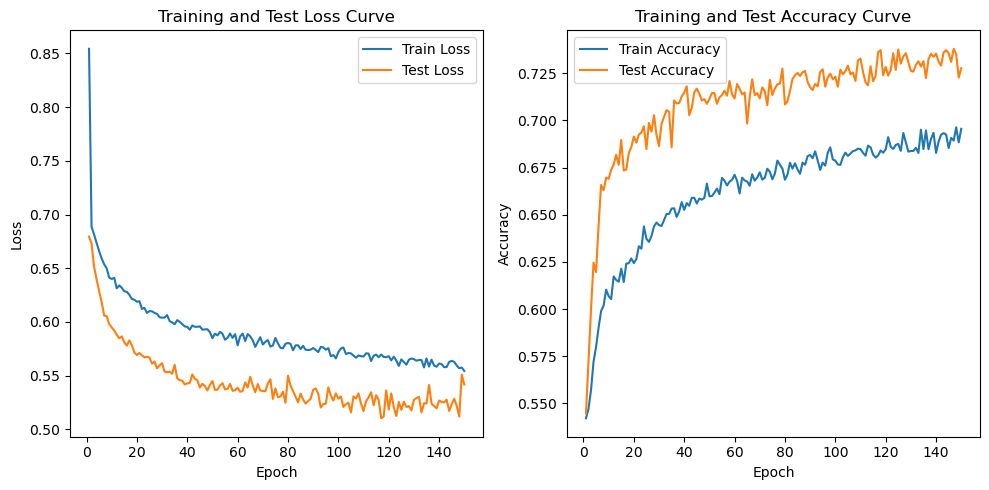

Best accuracy: 0.7379175550817342


In [27]:
model = vpnClassifier(sigma=4, embed_size=30, num_layers=1, heads=15, dropout=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.0001, momentum=0.9)

epochs = 150
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/150, Train Loss: 0.9225, Test Loss: 0.6846, Train Accuracy: 0.5322, Test Accuracy: 0.5792
Epoch 2/150, Train Loss: 0.6825, Test Loss: 0.6520, Train Accuracy: 0.5532, Test Accuracy: 0.6041
Epoch 3/150, Train Loss: 0.6709, Test Loss: 0.6409, Train Accuracy: 0.5743, Test Accuracy: 0.5897
Epoch 4/150, Train Loss: 0.6657, Test Loss: 0.6251, Train Accuracy: 0.5764, Test Accuracy: 0.6334
Epoch 5/150, Train Loss: 0.6506, Test Loss: 0.6138, Train Accuracy: 0.5914, Test Accuracy: 0.6459
Epoch 6/150, Train Loss: 0.6442, Test Loss: 0.6107, Train Accuracy: 0.5938, Test Accuracy: 0.6359
Epoch 7/150, Train Loss: 0.6387, Test Loss: 0.6041, Train Accuracy: 0.6017, Test Accuracy: 0.6571
Epoch 8/150, Train Loss: 0.6345, Test Loss: 0.6004, Train Accuracy: 0.6043, Test Accuracy: 0.6638
Epoch 9/150, Train Loss: 0.6247, Test Loss: 0.5968, Train Accuracy: 0.6151, Test Accuracy: 0.6599
Epoch 10/150, Train Loss: 0.6239, Test Loss: 0.5904, Train Accuracy: 0.6099, Test Accuracy: 0.6693
Epoch 11/150, Train

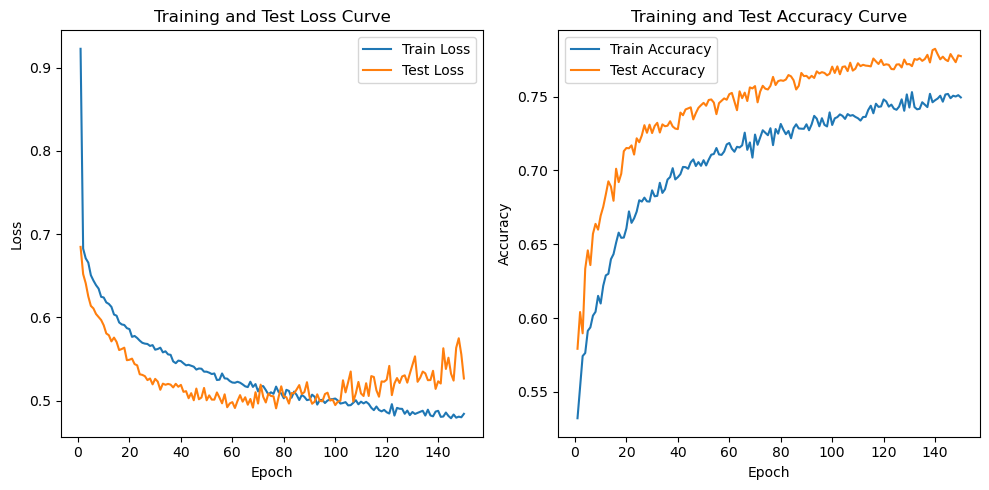

Best accuracy: 0.7823383084577115


In [32]:
model = vpnClassifier(sigma=4, embed_size=60, num_layers=1, heads=15, dropout=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.0001, momentum=0.9)

epochs = 150
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/150, Train Loss: 1.0944, Test Loss: 0.6926, Train Accuracy: 0.5034, Test Accuracy: 0.5211
Epoch 2/150, Train Loss: 0.6952, Test Loss: 0.6931, Train Accuracy: 0.5107, Test Accuracy: 0.5082
Epoch 3/150, Train Loss: 0.6943, Test Loss: 0.6918, Train Accuracy: 0.5094, Test Accuracy: 0.5213
Epoch 4/150, Train Loss: 0.6941, Test Loss: 0.6920, Train Accuracy: 0.5068, Test Accuracy: 0.5213
Epoch 5/150, Train Loss: 0.6940, Test Loss: 0.6919, Train Accuracy: 0.5127, Test Accuracy: 0.5213
Epoch 6/150, Train Loss: 0.6938, Test Loss: 0.6920, Train Accuracy: 0.5129, Test Accuracy: 0.5213
Epoch 7/150, Train Loss: 0.6937, Test Loss: 0.6920, Train Accuracy: 0.5203, Test Accuracy: 0.5213
Epoch 8/150, Train Loss: 0.6936, Test Loss: 0.6925, Train Accuracy: 0.5201, Test Accuracy: 0.5210
Epoch 9/150, Train Loss: 0.6938, Test Loss: 0.6924, Train Accuracy: 0.5132, Test Accuracy: 0.5213
Epoch 10/150, Train Loss: 0.6936, Test Loss: 0.6914, Train Accuracy: 0.5222, Test Accuracy: 0.5213
Epoch 11/150, Train

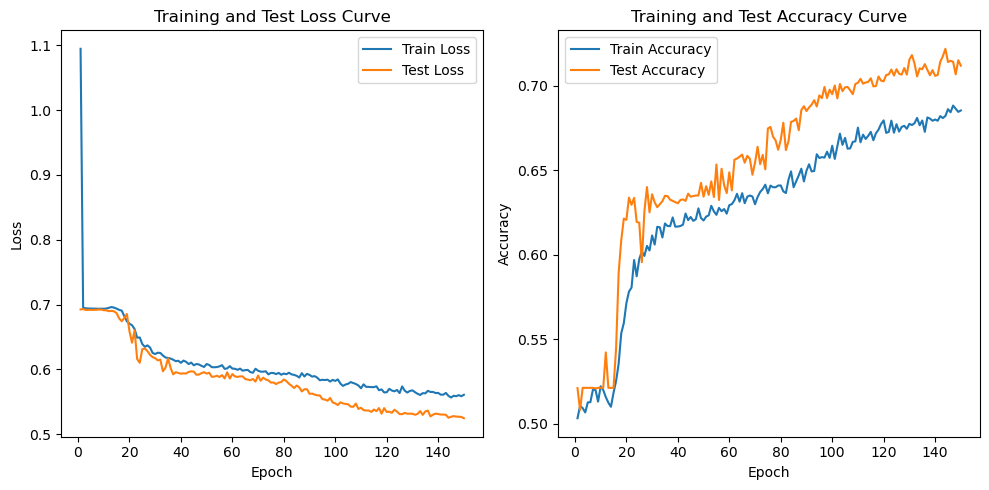

Best accuracy: 0.7217484008528785


In [34]:
model = vpnClassifier(sigma=4, embed_size=80, num_layers=2, heads=20, dropout=0.6)
loss_fn = nn.BCELoss()
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.0001, momentum=0.9)

epochs = 150
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")